<a href="https://colab.research.google.com/github/angelicago/MineracaoDados/blob/main/AnaliseRendimentoMedio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise de Árvore de Regressão em Indicadores de distribuição e desigualdade de renda.**


In [ ]:
install.packages("tidymodels")
install.packages("janitor")
install.packages("skimr")
install.packages("vip")
install.packages("rpart.plot")
install.packages("randomForest")

In [ ]:
library(tidyverse)
library(tidymodels)
library(janitor)
library(skimr) 
library(vip)
library(rpart.plot)
library(randomForest)

Carregando o conjunto de dados:

Após o carregamento dos dados será retirado a variável ano pois não será utilizado no modelo.

In [ ]:
dados <- read_csv2("https://raw.githubusercontent.com/angelicago/MineracaoDados/main/Rendimentos.csv")
dados$Ano <- NULL
dados <- janitor::clean_names(dados)
dados <- rename(dados,rendimento = rendimento_medio_mensal_no_trabalho_principal, localizacao = regiao_e_localizacao_do_domicilio )

dados <- dados |>
  mutate(cor_raca  = as.factor(cor_raca)) |>
  mutate(localizacao = as.factor(localizacao))|>
  mutate(sexo = as.factor(sexo))
glimpse(dados)


In [5]:
dados |>
  skim()

── Data Summary ────────────────────────
                           Values
Name                       dados 
Number of rows             152   
Number of columns          4     
_______________________          
Column type frequency:           
  factor                   3     
  numeric                  1     
________________________         
Group variables            None  

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts      
1 cor_raca              0             1 FALSE          2 Bra: 76, Neg: 76
2 localizacao           0             1 FALSE          2 Rur: 76, Urb: 76
3 sexo                  0             1 FALSE          2 Fem: 76, Mas: 76

── Variable type: numeric ──────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean   sd   p0  p25  p50   p75  p100
1 rendimento            0             1 1041. 703. 141. 480. 908. 1390. 2856.
  h

Warning message in is.null(text_repr) || nchar(text_repr) == 0L:
“'length(x) = 2 > 1' in coercion to 'logical(1)'”


**Exploração dos dados:**

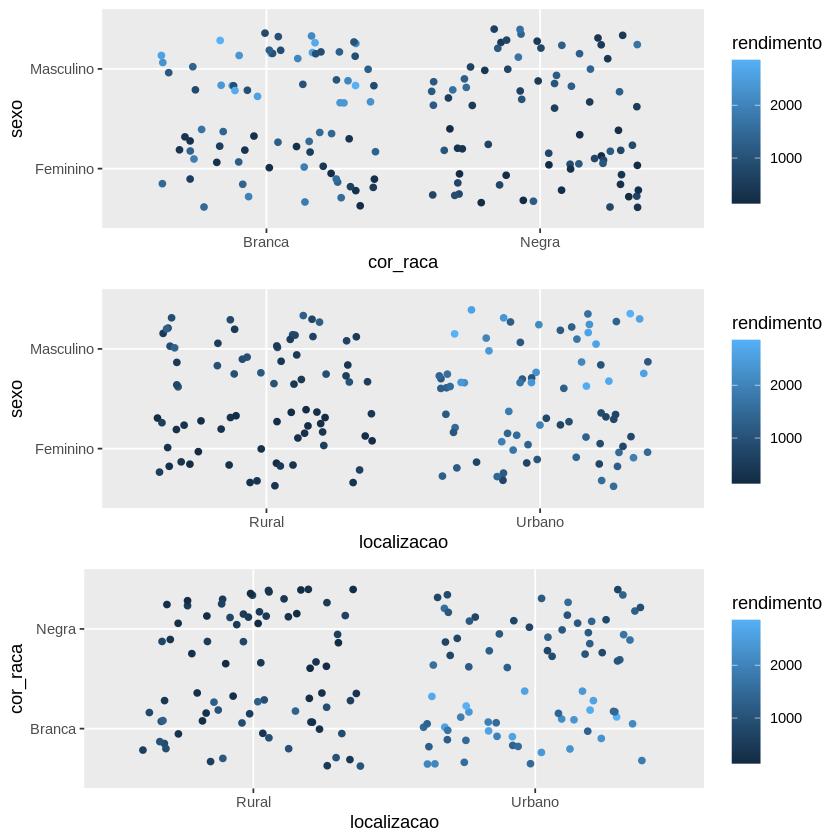

In [6]:
#par(mfrow=c(1,2))
plot1 <- ggplot(dados) + geom_jitter(aes(x =cor_raca, y = sexo, color = rendimento))
plot2 <- ggplot(dados) + geom_jitter(aes(x =localizacao, y = sexo, color = rendimento))
plot3 <- ggplot(dados) + geom_jitter(aes(x =localizacao, y = cor_raca, color = rendimento))
grid.arrange(plot1, plot2,plot3)

Os gráficos acima é possível observar as variações do rendimento, por exemplo, por cor/raça e sexo, pessoas negra e do sexo feminino a maioria tem um rendimento médio abaixo de  2.000 enquanto pessoas branca tem tanto do sexo masculino quanto feminino tem alguns que recebem mais que 1.000. E assim, podemos analizar os demais gráficos observando os eixos e a variação do tom de azul nos pontos.

In [7]:
dados |> group_by(sexo) |> summarise(media = mean(rendimento), 
                                             mediana = median(rendimento))

sexo,media,mediana
<fct>,<dbl>,<dbl>
Feminino,748.4447,652.75
Masculino,1332.8934,1134.95


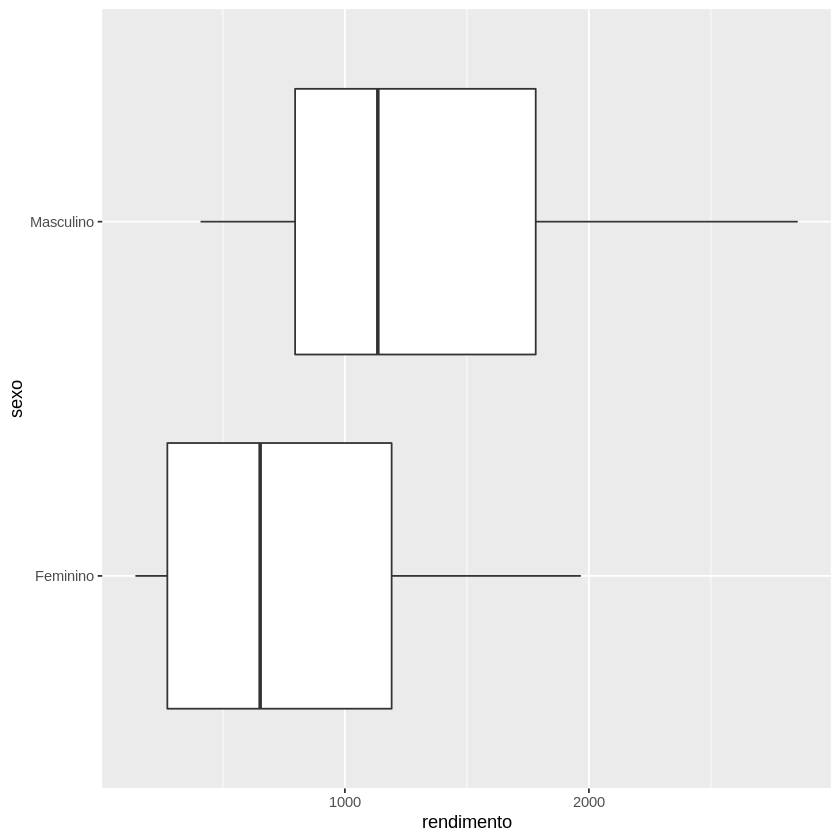

In [8]:
ggplot(dados) + geom_boxplot(aes(x =rendimento, y = sexo))

Analisando a média salarial e também o gráfico de boxplot percebe-se que há uma diferença salarial por sexo onde o sexo masculina aparenta ser maior que o feminino. Neste caso é interessante aplicar um teste de hipotese para verificar essa afirmação

**Teste de hipótese:**

**Hipótese Nula:** Salários para sexo Masculino e Feminino vêm da mesma distribuição, ou seja, tem a mesma média 

**Hipótese Alternativa:** média do salário do sexo Masculino é maior do que a média salarial para o sexo Feminino

In [9]:
salariosM <- dados |> filter(sexo == "Masculino")
salariosF <- dados |> filter(sexo == "Feminino")
wilcox.test(x = salariosM$rendimento, 
            y = salariosF$rendimento,
            alternative = "greater")
cat("Como p-value = 1.618e-07 então ficamos com a hipótese alternativa.")


	Wilcoxon rank sum test with continuity correction

data:  salariosM$rendimento and salariosF$rendimento
W = 4275, p-value = 1.618e-07
alternative hypothesis: true location shift is greater than 0


Como p-value = 1.618e-07 então ficamos com a hipótese alternativa.

**Variação do rendimento por cor_raça:**

Warning message:
“Ignoring unknown parameters: stat”


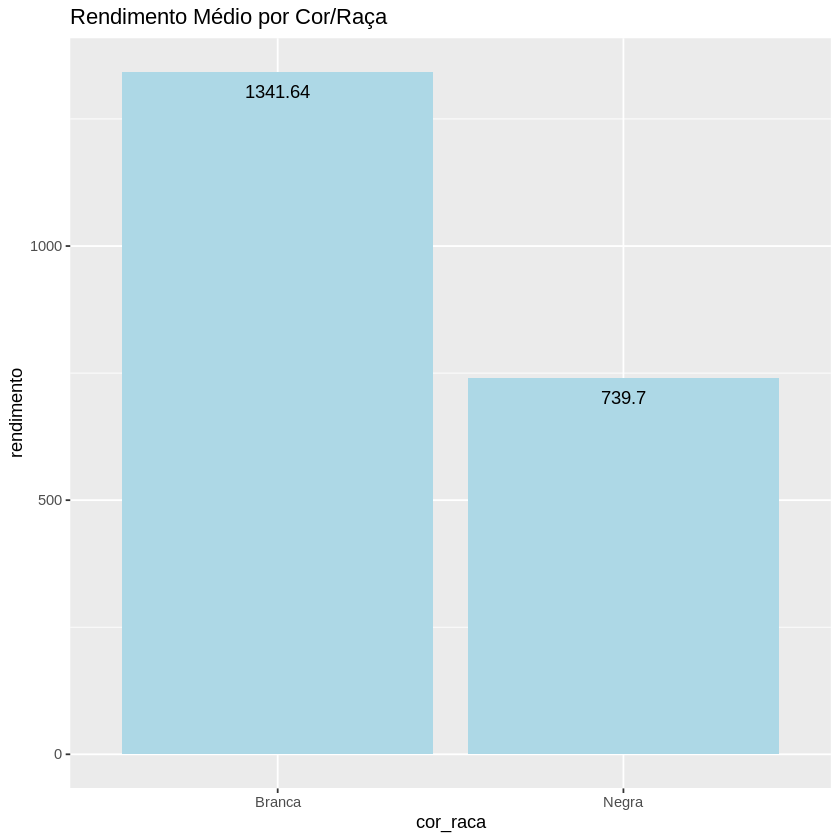

In [10]:
dados |>
  group_by(cor_raca) |>
  summarise(rendimento = round(mean(rendimento),2)) |> 
  ggplot(aes(x = cor_raca, y = rendimento)) +
  geom_col(stat="identity",fill="lightblue") +
  geom_text(aes(label = rendimento, vjust = 2))+
  ggtitle("Rendimento Médio por Cor/Raça")

Analisando o rendimento por raça é possível verificar que a média salarial para a cor/raça branca é maior do que para cor/raça negra.

**Variação do rendimento por localização:**

Warning message:
“Ignoring unknown parameters: stat”


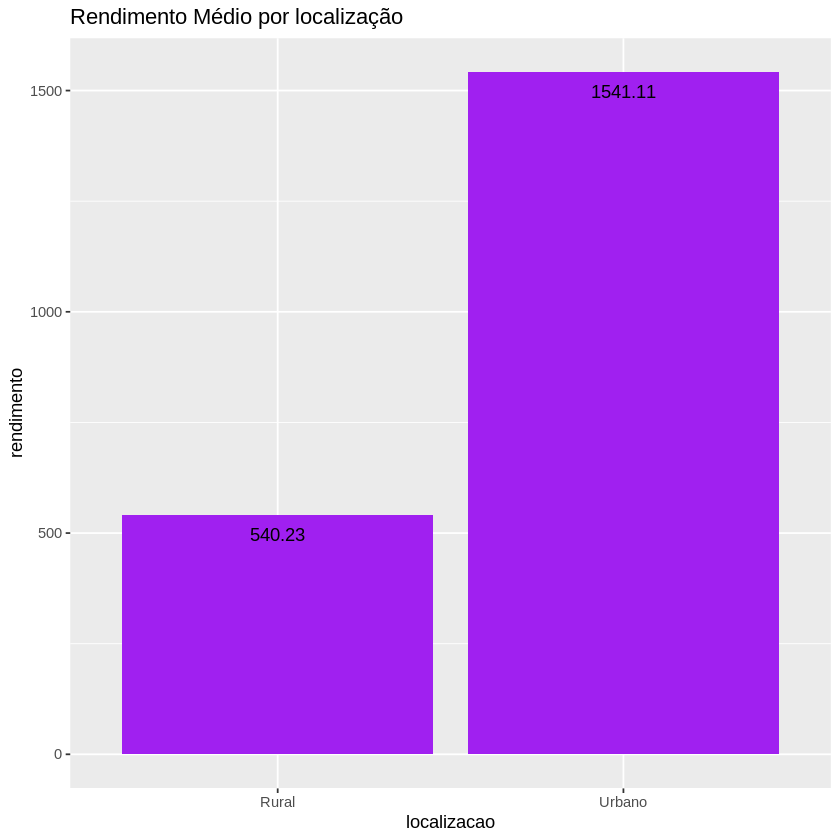

In [11]:
dados |>
  group_by(localizacao) |>
  summarise(rendimento = round(mean(rendimento),2)) |>
  ggplot(aes(x = localizacao, y = rendimento)) +
  geom_col(stat="identity",fill="purple") +
  geom_text(aes(label = rendimento, vjust = 2))+
   ggtitle("Rendimento Médio por localização")


Analisando o rendimento por localização é possível verificar que a média salarial para a zona urbana é maior do que para zona rural.


# **Transformação logarítmica na variável rendimento**

A transformação logarítmica pode auxiliar na distribuição da variável quando há: viés, extremidades elevadas e uma cauda longa, medidas de correlação ou regressão que podem ser influenciadas pelo pico da distribuição, outliers, dentre outros. A aplicação pode reduzir o efeito do viés.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



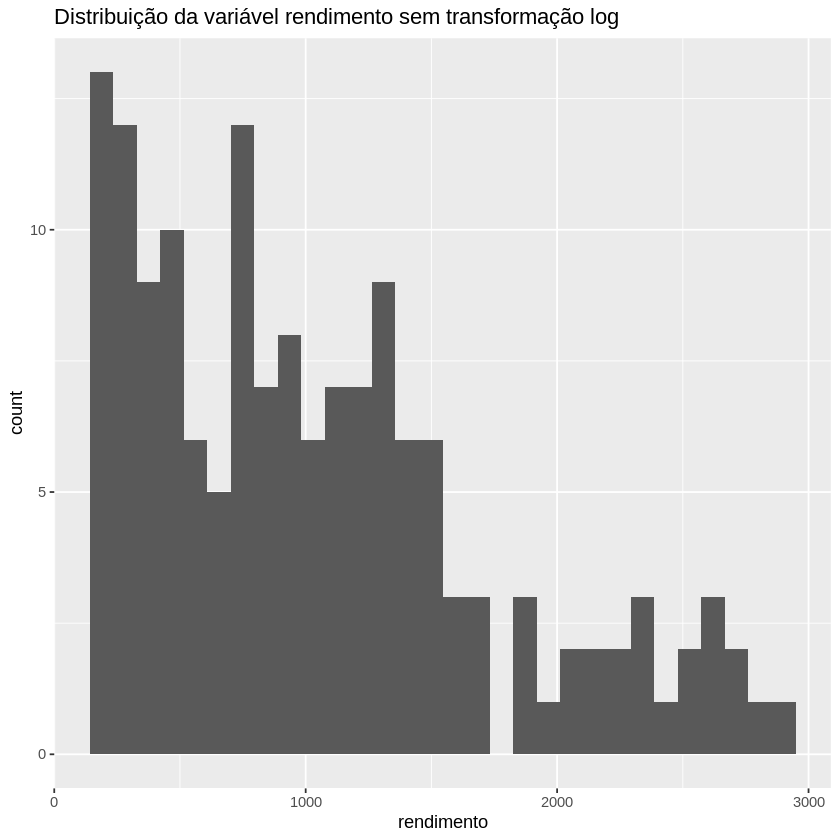

In [12]:
ggplot(data = dados, aes(x = rendimento)) +
  geom_histogram()+
  ggtitle("Distribuição da variável rendimento sem transformação log")

Percebe-se que a distribuição dos dados sem a aplicação da transformação logarítmica possuí uma falha antes de 2000 e também os dados estão bem concentrados à esquerda,conforme a figura mas ao transformar para o log na base 10 do valor original, temos os valores mais distribuídos.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



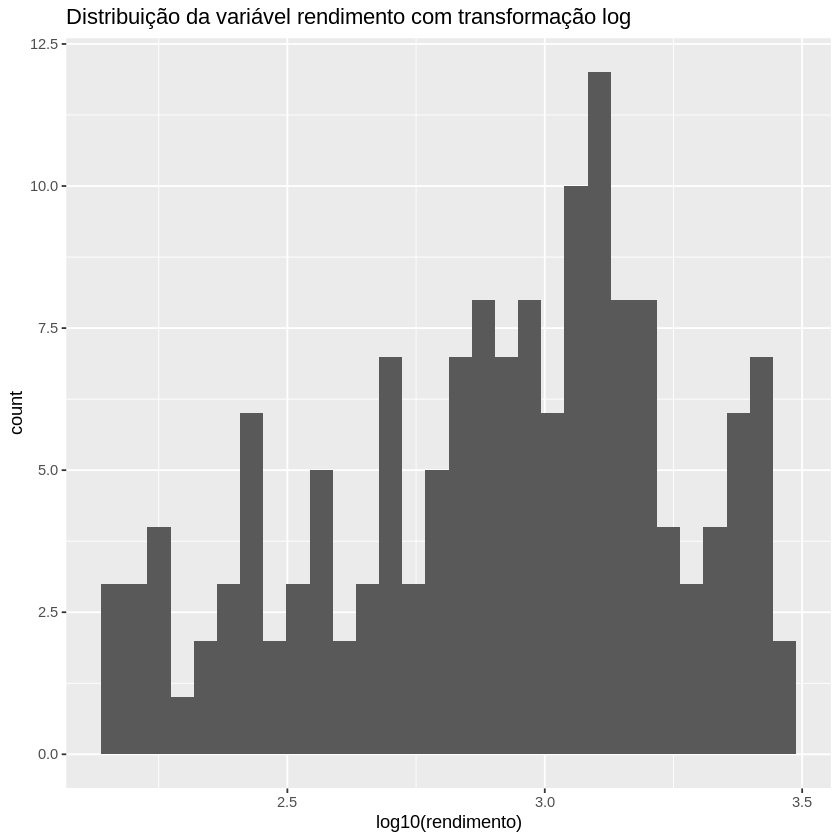

In [13]:
ggplot(data = dados, aes(x = log10(rendimento))) +
  geom_histogram()+
  ggtitle("Distribuição da variável rendimento com transformação log")

Logo, para esse estudo será aplicado a função logarítmica na variável target (rendimento médio).

In [14]:
dados$rendimento <- log10(dados$rendimento)

# **Árvores de Decisão:**

A árvore de decisão é especificadas como decision_tree() e possui três hiperparâmetros:cost_complexity (O parâmetro de complexidade de custo), tree_depthe (A profundidade máxima de uma árvore) e min_n (o número mínimo de pontos de dados em um nó que são necessários para que o nó seja dividido ainda mais). Para utilização dos ajustes de hiperparâmetros, será criado validação cruzada nos dados de treinamento.

**Separação dos dados entre treinamento e teste**

Essa separação é feito para testar a perfomance do modelo em dados não visto anteriormente e ajuda a evitar overfitting (ocorre quando o modelo tem um desempenho bom nos dados de treino mas nos dados de teste o resultado é ruim). Será utilizado 75% da base para treinar e os demais para testar. Os dados de treinamento serão divididos em 5 dobras de validação cruzada para ajuste de hiperparâmetros.

In [15]:
set.seed(314)
divisao_dados <- initial_split(data = dados,strata = "rendimento" ,prop = 0.75)
dados_treinamento <- training(divisao_dados)
dados_teste <- testing(divisao_dados)

set.seed(314)
cv <- vfold_cv(dados_treinamento, v = 5)

**Engenharia de Recurso:**

Nesta etapa será criado a receita de engenharia de recursos para o conjunto de dados.

In [49]:
receita <- recipe(rendimento  ~ ., data = dados_treinamento) |> prep(training = dados_treinamento, retain = TRUE)
                      # step_dummy(all_nominal(), -all_outcomes())

Verificando se as etapas de engenharia de recursos foram executadas corretamente.

In [50]:
receita |> 
  prep() |>
  bake(new_data = dados_treinamento) |> slice(1:5)

cor_raca,localizacao,sexo,rendimento
<fct>,<fct>,<fct>,<dbl>
Negra,Rural,Masculino,2.661529
Negra,Rural,Masculino,2.635685
Negra,Rural,Masculino,2.620552
Negra,Rural,Masculino,2.611298
Branca,Rural,Feminino,2.346939


**Especificação modelo:**

Para a criação do modelo será utilizado o mecanismo rpart que permitirá fazer gráficos do modelo de árvore de decisão com a função rpart.plot

In [51]:
arvoredecisao <- decision_tree(cost_complexity = tune(),
                               tree_depth = tune(),
                               min_n = tune()) |>
              set_engine('rpart') |> 
              set_mode('regression')

**Fluxo de trabalho:**
Combinando o modelo e a receita em um fluxo de trabalho para gerenciar facilmente o processo de construção do modelo.

In [52]:
tree_workflow <- workflow() |>
                 add_model(arvoredecisao) |>
                 add_recipe(receita)

**Ajuste de hiperparâmetro:**
Para modelos com múltiplos hiperparâmetros, tidymodels tem a função grid_regular() que cria automaticamente uma grade de ajuste com combinações de valores de hiperparâmetros sugeridos.Essa função recebe os hiperparâmetros com o argumentos levels (opção é usada para determinar o número de valores a serem criados para cada hiperparâmetro exclusivo).


In [53]:
tree_grid <- grid_regular(cost_complexity(),
                          tree_depth(),
                          min_n() 
                          )
tree_grid |> slice(1:5)

cost_complexity,tree_depth,min_n
<dbl>,<int>,<int>
1.000000e-10,1,2
3.162278e-06,1,2
1.000000e-01,1,2
1.000000e-10,8,2
3.162278e-06,8,2


Ajustando hiperparâmetros com tune_grid():
Para encontrar a combinação ideal de hiperparâmetros de nossa grade de ajuste, usaremos a função tune_grid()

In [54]:
set.seed(314)
tree_tuning <- tree_workflow |>
               tune_grid(resamples = cv,
                         grid = tree_grid)

Para visualizar os resultados do ajuste de hiperparâmetros, pode-se utilizar a função show_best(). Deve se passado o tipo de métrica de desempenho que deseja ver na função show_best().

A partir dos resultados abaixo, para cada combinação de hiperparâmetros na grade, tune_grid() ajusta um modelo de árvore de decisão com essa combinação 5 vezes (já que temos 5 dobras em nosso objeto de validação cruzada).

A coluna dos resultados mean abaixo indica o valor médio da métrica de desempenho que foi obtida.


In [55]:
tree_tuning |> show_best(metric = "rmse")

cost_complexity,tree_depth,min_n,.metric,.estimator,mean,n,std_err,.config
<dbl>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1.000000e-10,8,2,rmse,standard,0.09535053,5,0.006510618,Preprocessor1_Model04
3.162278e-06,8,2,rmse,standard,0.09535053,5,0.006510618,Preprocessor1_Model05
1.000000e-10,15,2,rmse,standard,0.09535053,5,0.006510618,Preprocessor1_Model07
3.162278e-06,15,2,rmse,standard,0.09535053,5,0.006510618,Preprocessor1_Model08
1.000000e-10,8,21,rmse,standard,0.10854717,5,0.006191355,Preprocessor1_Model13


Pode-se utiliar o select_best() modelo para selecionar o modelo dos resultados de ajuste que teve o melhor desempenho geral. No código abaixo, é especificado para selecionar o melhor modelo de desempenho com base no rmse (calcula o quão próximo os pontos de dados reais estão dos valores previstos pelo modelo e é usado para medir o desvio padrão dos resíduos).

Vemos que o modelo com complexidade de custo de 1 -10 , profundidade de árvore de 15 e mínimo n de 2 produziu o melhor modelo.

In [56]:
best_tree <- tree_tuning |> 
             select_best(metric = "rmse")
best_tree             

cost_complexity,tree_depth,min_n,.config
<dbl>,<int>,<int>,<chr>
1e-10,8,2,Preprocessor1_Model04


**Finalizar fluxo de trabalho:**

A última etapa no ajuste de hiperparâmetro é usar finalize_workflow() para adicionar no modelo ideal ao objeto de fluxo de trabalho.

In [57]:
final_tree_workflow <- tree_workflow |>
                       finalize_workflow(best_tree)

**Visualizar resultados e Ajustar o modelo:**

Para visualizar o modelo de árvore de decisão, precisa treinar manualmente o objeto de fluxo de trabalho com a função fit().

In [58]:
tree_wf_fit <- final_tree_workflow |> 
               fit(data = dados_treinamento)

**Explorando o modelo treinado:**

Uma vez que é treinado o modelo em no conjunto de dados de treinamento, pode-se estudar a importância variável com a função vip().

A primeira etapa é extrair o modelo treinado de nosso ajuste de fluxo de trabalho, tree_wf_fit. Isso pode ser feito passando tree_wf_fit para a função extract_fit_parsnip().

In [59]:
tree_fit <- tree_wf_fit |>
            extract_fit_parsnip()

**Importância das variáveis:**

Em seguida passamos tree_fit para a função vip(). Isso retornará um ggplot com as pontuações de importância da variável do modelo. As pontuações de importância são baseadas nos critérios de divisão da árvore de decisão treinada.

Analisando o resultados do gráfico abaixo as variáveis: localizacao_Urbano, sexo_Masculino, cor_raca_Negra são os preditores mais importantes para rendimento médio.

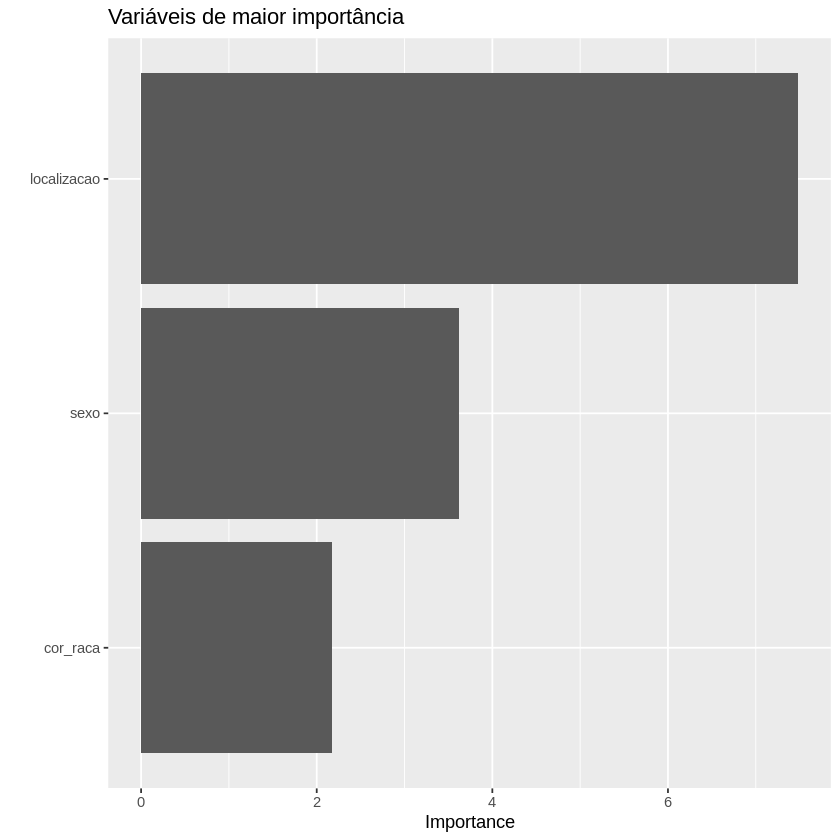

In [60]:
vip(tree_fit) +
   ggtitle("Variáveis de maior importância")

**Gráfico da Árvore de Decisão**

Visualizando a árvore de decisão treinada usando a função rpart.plot() do pacote rpart.plot. Deve-se passar o objeto fit armazenado dentro tree_fit da função rpart.plot() para fazer um gráfico de árvore de decisão.

O primeiro nó significa que 100% das observações possui rendimento médio de 2.9 (nessa etapa ainda **não** foi feito nenhuma divisão).
Primeira divisão: É verificar se a localização é rural ou **não**. Se for rural o rendimento médio é de 2.6(50%), se **não**, ou seja, zona urbana, o rendimento médio é 3.2(50%). 
Na próxima divisão se **não** for da zona rural e a cor/raça é negra então o rendimento médio é de 3 (27%) se **não**, ou seja, cor/raça for branca então o rendimento é de 3.3 (23%). Continuando a análise para zona urbana, o próximo nível é o sexo, se a cor/raça é negra e o sexo é feminino então o rendimento médio é de 2.9 (12%), se a cor/raça é negra e o sexo é masculino o rendimento médio é de 3.1 (14%). Já se a cor/raça é branca e o sexo é feminino então o rendimento médio é de 3.2 (10%) e se a cor/raça é branca e o sexo é masculino o rendimento médio é de 3.4 (13%).
Na divisão para zona urbana: Se o sexo é feminino então o rendimento médio é de 2.4(24%) e se for masculino 2.9(26%). Próximo nível é cor/raça, se o sexo é feminino e a cor/raça negra então o rendimento médio é de 2.3(12%) e se a raça for branca o rendimento é de 2.5(12%). Se o sexo é masculino e cor/raça é negra então o rendimento médio é 2.7(13%) e se a cor/raça é branca então o rendimento é 3(12%).



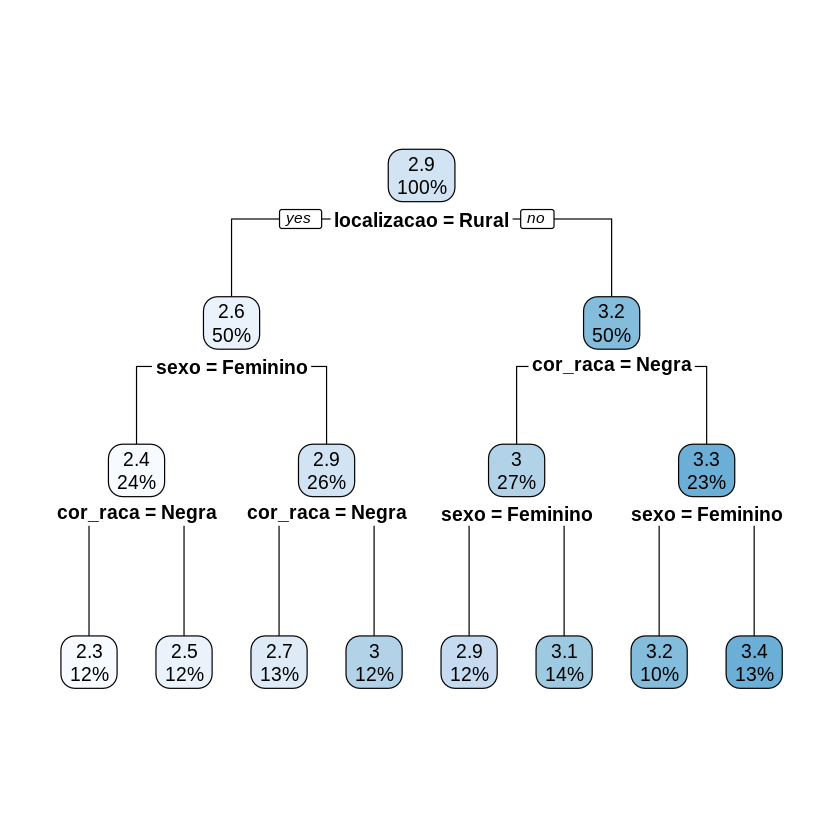

In [61]:
rpart.plot(tree_fit$fit, roundint = FALSE)

**Treinando e avaliando o modelo:**

Ajustando o fluxo de trabalho do modelo final aos dados de treinamento e avaliando o desempenho nos dados de teste.

A função last_fit() ajustará o fluxo de trabalho aos dados de treinamento e gerará previsões nos dados de teste conforme definido pela divisão dos dados.

In [62]:
tree_last_fit <- final_tree_workflow |>
                 last_fit(divisao_dados)

**Visualizando as métricas de desempenho nos dados de teste.**

O RMSE é a raiz quadrada média dos erro entre valores reais e preditos. Ele calcula o quão próximo os pontos de dados reais estão dos valores previstos pelo modelo. Quanto menor esse valor, melhor.

rqs é o erro quadrado, ele representa a proporção da variância para uma variável dependente que é explicada pela outras variáveis independentes. Um valor alto calculado indica que o modelo se ajustou bem aos dados.

In [63]:
tree_last_fit |> 
  collect_metrics(truth = rendimento, estimate = .pred)

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
rmse,standard,0.1116695,Preprocessor1_Model1
rsq,standard,0.9109596,Preprocessor1_Model1


In [64]:
tree_last_fit <- 
  dados_teste |>
  select(rendimento) |>
  bind_cols(
    collect_predictions(tree_last_fit, new_data = dados_teste)
  )
tree_last_fit <- janitor::clean_names(tree_last_fit)
tree_last_fit <- 
  tree_last_fit |>
  rename(rendimento = rendimento_1) 
tree_last_fit |> select(rendimento,pred) |> slice(1:5)

New names:
• `rendimento` -> `rendimento...1`
• `rendimento` -> `rendimento...5`


rendimento,pred
<dbl>,<dbl>
2.689753,2.731253
2.983626,2.991622
2.984122,2.991622
3.369012,3.391497
2.924796,2.991622


# **Floresta Aleatória:**

O modelo de Florestas aleatórias pegam árvores de decisão e constroem modelos mais poderosos em termos de precisão e previsão. O principal mecanismo que alimenta esse algoritmo é a amostragem repetida (com substituição) dos dados de treinamento para produzir uma sequência de modelos de árvore de decisão. Esses modelos são calculados para obter uma única previsão para um determinado valor no espaço do preditor.

O modelo de floresta aleatória seleciona um subconjunto aleatório de variáveis de previsão para dividir o espaço de previsão no processo de construção da árvore. Isso é feito para cada iteração do algoritmo, normalmente 100 a 2.000 vezes.

**Engenharia de Recurso:**

Especificação de um classificador de floresta aleatória com os seguintes hiperparâmetros:

- mtry: o número de preditores que serão amostrados aleatoriamente em cada divisão ao criar os modelos de árvore
- trees: O número de árvores de decisão a serem ajustadas 
- min_n: O número mínimo de pontos de dados em um nó 

Será utilizado a engenharia de randomForest

In [65]:
rf_model <- rand_forest(
    mode = "regression",
    mtry = tune(),
    trees = tune(),
    min_n = tune()
  ) |>
  set_engine("randomForest")
rf_model

Random Forest Model Specification (regression)

Main Arguments:
  mtry = tune()
  trees = tune()
  min_n = tune()

Computational engine: randomForest 


**Fluxo de trabalho:**

Em seguida, será combinado o modelo e a receita em um fluxo de trabalho para gerenciar facilmente o processo de construção do modelo.

In [66]:
rf_workflow <- workflow() |>
               add_model(rf_model) |>
               add_recipe(receita)

**Ajuste de hiperparâmetro:**

A pesquisa de grade aleatória é implementada com a função grid_random() em tidymodels. Como se grid_regular() fosse uma sequência de nomes de hiperparâmetros para criar a grade. Ele também possui um size parâmetro que especifica o número de combinações aleatórias a serem criadas.

O mtry() hiperparâmetro requer um intervalo predefinido de valores para teste, pois não pode exceder o número de colunas em no conjunto de dados. Quando é adicionado o grid_random(), pode-se passar mtry()para a função range_set() e definir um intervalo para o hiperparâmetro com um vetor numérico.

In [67]:
set.seed(314)
dials_random <- grid_random(
  mtry(c(1, ncol(dados_treinamento) - 1)),
  trees(),
  min_n(),
  size = 6
)
dials_random

mtry,trees,min_n
<int>,<int>,<int>
2,1855,27
3,1644,25
3,1440,30
3,1549,22
2,1734,34
2,332,20


**Ajustando hiperparâmetros com tune_grid()**

Para encontrar a combinação ideal de hiperparâmetros da grade de ajuste, utiliza-se a função tune_grid().

In [68]:
set.seed(314)
rf_tuning <-
  rf_workflow |>
  tune_grid(
    resamples = cv, grid = dials_random
  )
show_best(rf_tuning, n = 1)

Warning message:
“No value of `metric` was given; metric 'rmse' will be used.”


mtry,trees,min_n,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,332,20,rmse,standard,0.1093131,5,0.005667786,Preprocessor1_Model6


In [69]:
best_rf <- rf_tuning |> 
             select_best()
best_rf

Warning message:
“No value of `metric` was given; metric 'rmse' will be used.”


mtry,trees,min_n,.config
<int>,<int>,<int>,<chr>
2,332,20,Preprocessor1_Model6


**Fluxo de trabalho:**

A última etapa no ajuste de hiperparâmetro é usar finalize_workflow() para adicionar no modelo ideal ao objeto de fluxo de trabalho

In [70]:
final_rf_workflow <- rf_workflow |>
                     finalize_workflow(best_rf)

**Ajuste o modelo:**

ajustamos o fluxo de trabalho aos dados de treinamento. Isso é feito passando o objeto de fluxo de trabalho para a função fit().


In [71]:
rf_wf_fit <- final_rf_workflow %>% 
             fit(data = dados_treinamento)

Uma vez que é treinado o modelo no conjunto dados de treinamento, pode-se estudar a importância variável com a função vip().

A primeira etapa é extrair o modelo treinado de nosso ajuste de fluxo de trabalho, rf_wf__fit. Isso pode ser feito passando rf_wf__fit para a função extract_fit_parsnip().

In [86]:
rf_fit <- rf_wf_fit |>
          extract_fit_parsnip()

**Importância variável:**

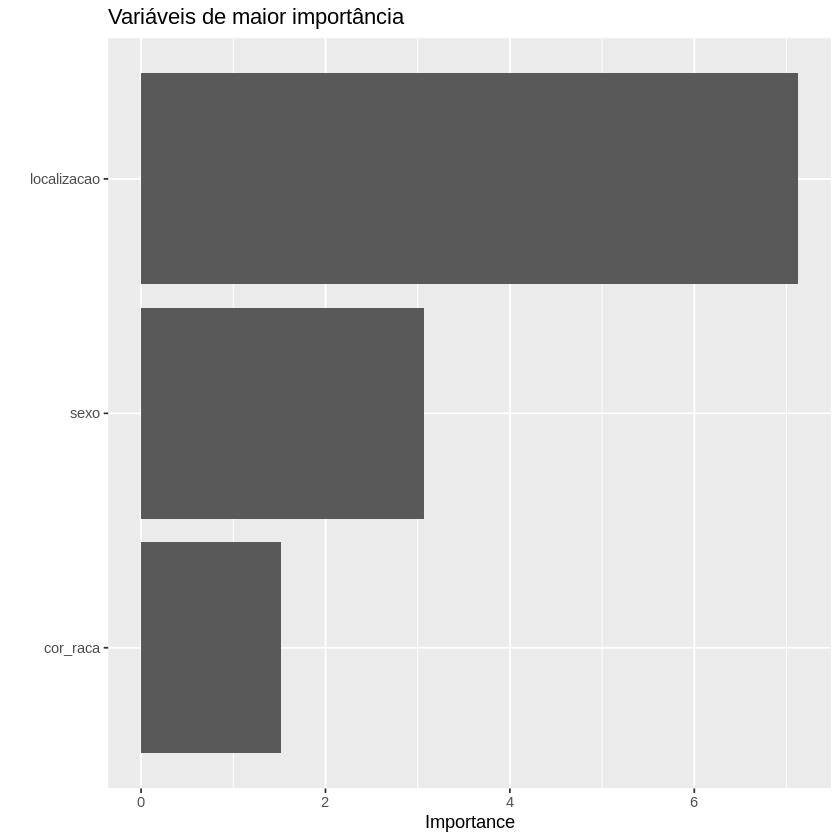

In [87]:
vip(rf_fit)+
     ggtitle("Variáveis de maior importância")

**Treine e avalie com last_fit()**

Em seguida, ajustamos nosso fluxo de trabalho do modelo final aos dados de treinamento e avaliando o desempenho nos dados de teste.

A função last_fit() ajustará nosso fluxo de trabalho aos dados de treinamento e gerará previsões nos dados de teste conforme definido pela divisão de dados.

In [80]:
rf_last_fit <- final_rf_workflow |>
               last_fit(divisao_dados)

In [81]:
rf_last_fit |> 
  collect_metrics(truth = rendimento, estimate = .pred)

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
rmse,standard,0.1018875,Preprocessor1_Model1
rsq,standard,0.9078892,Preprocessor1_Model1


**Ajustando o modelo aos dados dados de teste:**

In [82]:
rf_last_fit <- 
  dados_teste |>
  select(rendimento) |>
  bind_cols(
    collect_predictions(rf_last_fit, new_data = dados_teste)
  )
rf_last_fit <- janitor::clean_names(rf_last_fit)
rf_last_fit <- 
  rf_last_fit |>
  rename(rendimento = rendimento_1) 
rf_last_fit |> select(rendimento,pred) |> slice(1:5)

New names:
• `rendimento` -> `rendimento...1`
• `rendimento` -> `rendimento...5`


rendimento,pred
<dbl>,<dbl>
2.689753,2.741014
2.983626,2.953515
2.984122,2.953515
3.369012,3.350162
2.924796,2.953515


Comparando o valor predito da árvore de decisão e da floresta aleátoria

In [83]:
test_normalized <- bake(receita, new_data = dados_teste, all_predictors())

rf_last_fit <- 
  rf_last_fit |>
  rename(`random forest` = pred) |>
  bind_cols(
    tree_last_fit |>
      rename(`arvore decisao` = pred)
  )
rf_last_fit <- janitor::clean_names(rf_last_fit)
rf_last_fit <- 
  rf_last_fit |>
  rename(rendimento = rendimento_1) 
rf_last_fit |> select(rendimento,random_forest,arvore_decisao) |> slice(1:5)

New names:
• `rendimento` -> `rendimento...1`
• `id` -> `id...2`
• `row` -> `row...4`
• `rendimento_5` -> `rendimento_5...5`
• `config` -> `config...6`
• `rendimento` -> `rendimento...7`
• `id` -> `id...8`
• `row` -> `row...10`
• `rendimento_5` -> `rendimento_5...11`
• `config` -> `config...12`


rendimento,random_forest,arvore_decisao
<dbl>,<dbl>,<dbl>
2.689753,2.741014,2.731253
2.983626,2.953515,2.991622
2.984122,2.953515,2.991622
3.369012,3.350162,3.391497
2.924796,2.953515,2.991622


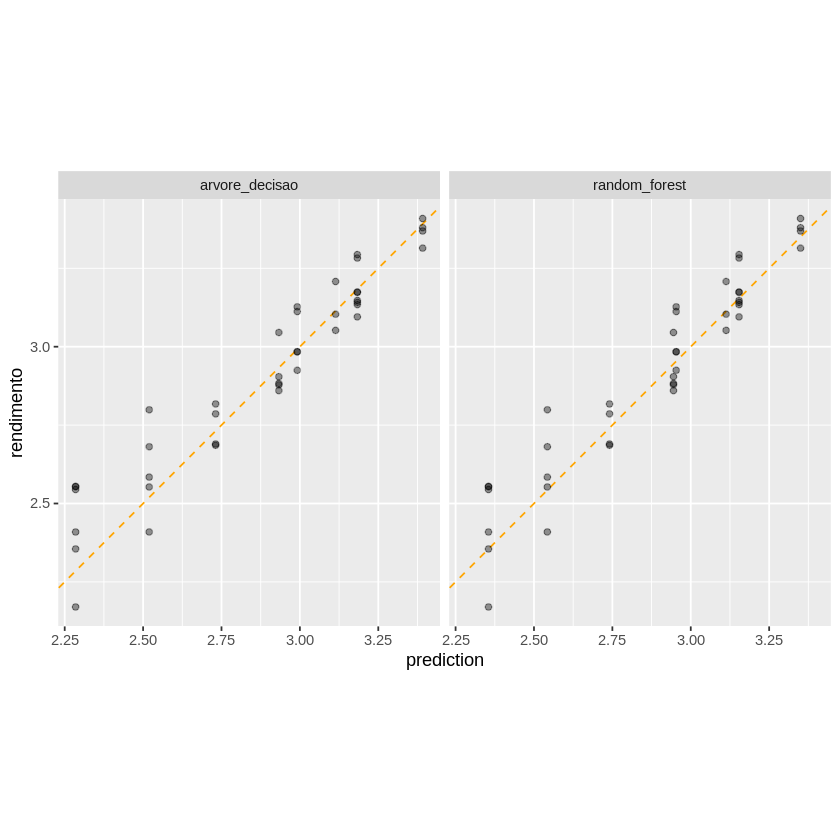

In [84]:
rf_last_fit |>
  gather(model, prediction, random_forest,arvore_decisao) |>
  ggplot(aes(x = prediction, y = rendimento)) + 
  geom_abline(col = "orange", lty = 2) + 
  geom_point(alpha = .4) + 
  facet_wrap(~model) + 
  coord_fixed()

Os dois modelos obtiveram um bom resultado. A árvore de decisão teve uma rsq de 91% enquanto o da floresta aletória teve 90%. Isso mostra que tanto o modelo de árvore de decisão quanto o de floresta aleatória pode ser utilizado para explicar a variação do rendimento médio por sexo, cor/raça e localização.